In [1]:
# Core
import pandas as pd
import numpy as np
from pathlib import Path

# Pre‑processing / ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Paths
df_raw = pd.read_csv("./data/clean/country_snapshot_master.csv")

In [2]:
# Make sure numeric features are really numeric
numeric_cols = df_raw.columns.drop("iso3")
df_raw[numeric_cols] = df_raw[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Drop any rows left with NaNs (quick‑n‑dirty)
df_raw = df_raw.dropna(subset=numeric_cols).reset_index(drop=True)
print(df_raw.shape)        # rows, cols sanity‑check

(216, 16)


In [3]:
scaler = StandardScaler()

# Fit on *all* numeric columns at once and transform
scaled = scaler.fit_transform(df_raw[numeric_cols])

# Re‑assemble as a DataFrame, keeping iso3 for reference
df_scaled = pd.DataFrame(
    scaled,
    columns=numeric_cols,
    index=df_raw["iso3"]        # makes iso3 the index
).reset_index()                 # …or keep as column if you prefer

# Persist to disk
# df_scaled.to_csv("notebooks/data/clean/scaled_no_pillars.csv", index=False)
# print(f"Scaled file saved to → notebooks/data/clean/scaled_no_pillars.csv")


In [4]:
# Keep enough components to explain ~90‑95 % of the variance
pca = PCA(n_components=0.95, svd_solver="full")
principal_components = pca.fit_transform(df_scaled[numeric_cols])

# Scree / variance summary
explained = np.round(100 * pca.explained_variance_ratio_, 2)
cum_exp   = np.round(100 * np.cumsum(pca.explained_variance_ratio_), 2)
for i, (var, cum) in enumerate(zip(explained, cum_exp), start=1):
    print(f"PC{i:2}: {var:5.2f}%  (cumulative {cum:5.2f}%)")

# Save PC scores if you want to use them downstream
df_pca = pd.DataFrame(
    principal_components,
    columns=[f"pc{i}" for i in range(1, principal_components.shape[1]+1)],
    index=df_scaled["iso3"]
).reset_index()
# df_pca.to_csv("notebooks/data/clean/pca_scores_no_pillars.csv", index=False)
# print(f"PCA scores saved to → notebooks/data/clean/pca_scores_no_pillars.csv")


PC 1: 24.94%  (cumulative 24.94%)
PC 2: 10.51%  (cumulative 35.46%)
PC 3:  9.69%  (cumulative 45.15%)
PC 4:  7.47%  (cumulative 52.61%)
PC 5:  7.26%  (cumulative 59.88%)
PC 6:  6.99%  (cumulative 66.87%)
PC 7:  6.46%  (cumulative 73.34%)
PC 8:  5.89%  (cumulative 79.23%)
PC 9:  5.36%  (cumulative 84.59%)
PC10:  3.93%  (cumulative 88.52%)
PC11:  3.60%  (cumulative 92.12%)
PC12:  2.75%  (cumulative 94.87%)
PC13:  2.40%  (cumulative 97.26%)


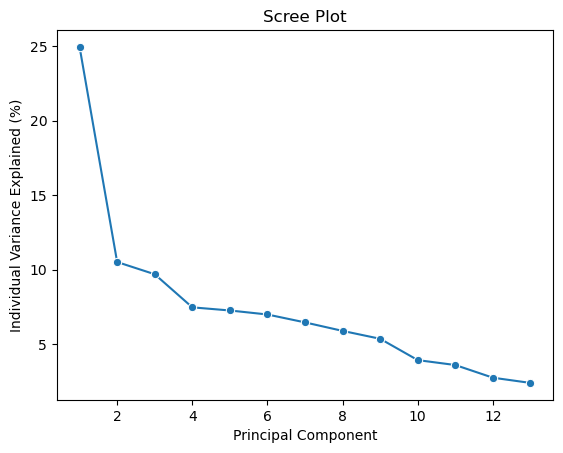

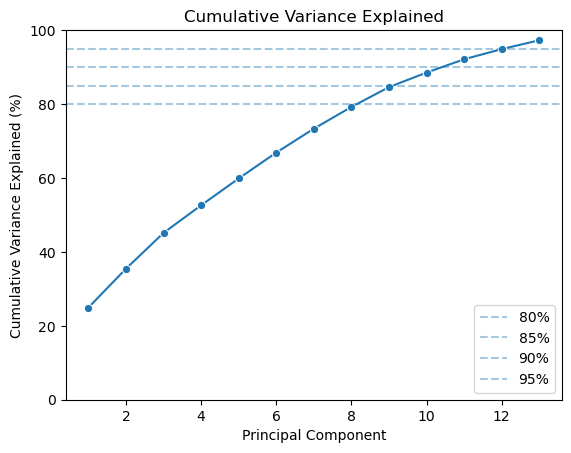

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns  # only for nicer scree plot styling

# --- Scree plot -------------------------------------------------
fig, ax = plt.subplots()
sns.lineplot(x=range(1, len(explained)+1), y=explained, marker="o", ax=ax)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Individual Variance Explained (%)")
ax.set_title("Scree Plot")
plt.show()

# --- Cumulative plot with cut lines ----------------------------
fig, ax = plt.subplots()
sns.lineplot(x=range(1, len(cum_exp)+1), y=cum_exp, marker="o", ax=ax)
for thresh in [0.8, 0.85, 0.9, 0.95]:
    ax.axhline(thresh*100, ls="--", alpha=0.4, label=f"{int(thresh*100)}%")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Cumulative Variance Explained (%)")
ax.set_ylim(0, 100)
ax.legend()
ax.set_title("Cumulative Variance Explained")
plt.show()


In [6]:
n_keep = 11                
pcs_for_model = df_pca.iloc[:, 1:1+n_keep]   # iso3 is column 0
print(f"Using the first {n_keep} PCs for clustering.")


Using the first 11 PCs for clustering.


## Below is the clustering method using KMeans

c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

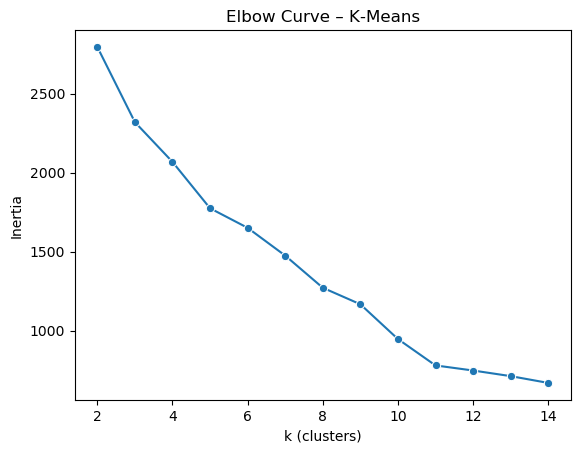

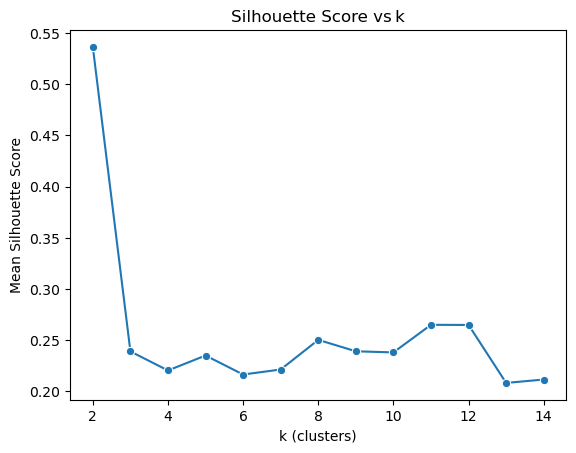

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

inertias, silhouettes = [], []
K_RANGE = range(2, 15)   # 1‑cluster not meaningful

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(pcs_for_model)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(pcs_for_model, labels))

# --- Elbow plot -------------------------------------------------------
fig, ax = plt.subplots()
sns.lineplot(x=list(K_RANGE), y=inertias, marker="o", ax=ax)
ax.set_xlabel("k (clusters)")
ax.set_ylabel("Inertia")
ax.set_title("Elbow Curve – K‑Means")
plt.show()

# --- Silhouette plot --------------------------------------------------
fig, ax = plt.subplots()
sns.lineplot(x=list(K_RANGE), y=silhouettes, marker="o", ax=ax)
ax.set_xlabel("k (clusters)")
ax.set_ylabel("Mean Silhouette Score")
ax.set_title("Silhouette Score vs k")
plt.show()


In [29]:
# ---------------------------------------------------------------
# FINAL K‑Means fit with chosen cluster count
# ---------------------------------------------------------------
BEST_K = 11                     # <—— updated after diagnostics
kmeans = KMeans(n_clusters=BEST_K, n_init="auto", random_state=42)
df_pca["cluster"] = kmeans.fit_predict(pcs_for_model)

# sanity‑check distribution
display(df_pca["cluster"].value_counts().sort_index())

# save labels (same path you used before)
# out_path = "./data/clean/cluster_no_pillars3.csv"
# df_pca[["iso3", "cluster"]].to_csv(out_path, index=False)
# print(f"Cluster labels saved → {out_path}")


c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
0      2
1     15
2     86
3     17
4     41
5      1
6      3
7      1
8     47
9      1
10     2
Name: count, dtype: int64

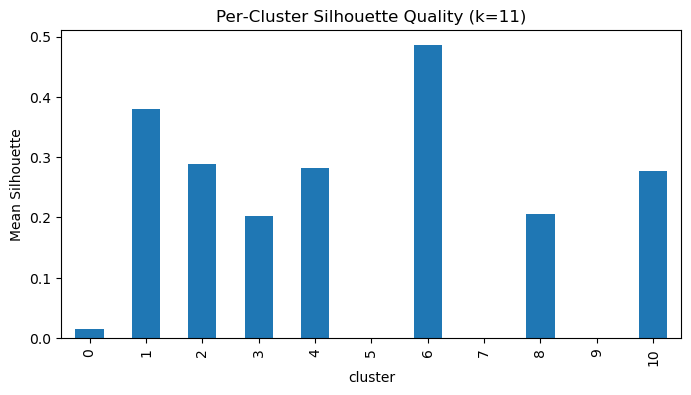

In [30]:
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.pyplot as plt

sample_scores = silhouette_samples(pcs_for_model, df_pca["cluster"])
df_pca["silhouette"] = sample_scores

# bar plot of mean silhouette per cluster
cluster_means = df_pca.groupby("cluster")["silhouette"].mean().sort_index()
cluster_means.plot(kind="bar", figsize=(8,4))
plt.ylabel("Mean Silhouette")
plt.title("Per‑Cluster Silhouette Quality (k=11)")
plt.show()


# Below is a follow-up using DBSCAN
## (Did not use this method)

In [7]:
MIN_SAMPLES = 22      # tweak later if needed

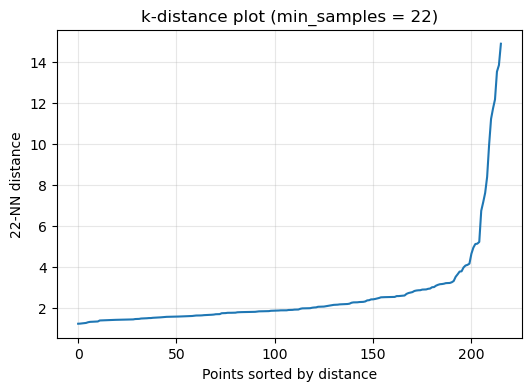

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit k‑NN on the PCA space
neigh = NearestNeighbors(n_neighbors=MIN_SAMPLES)
nbrs  = neigh.fit(pcs_for_model)
distances, _ = nbrs.kneighbors(pcs_for_model)

# distances[:, -1] gives distance to the MIN_SAMPLES‑th neighbor
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.ylabel(f"{MIN_SAMPLES}‑NN distance")
plt.xlabel("Points sorted by distance")
plt.title(f"k‑distance plot (min_samples = {MIN_SAMPLES})")
plt.grid(alpha=0.3)
plt.show()


Cluster counts:
 cluster_db
-1     11
 0    205
Name: count, dtype: int64 

Not enough clustered points to compute silhouette.


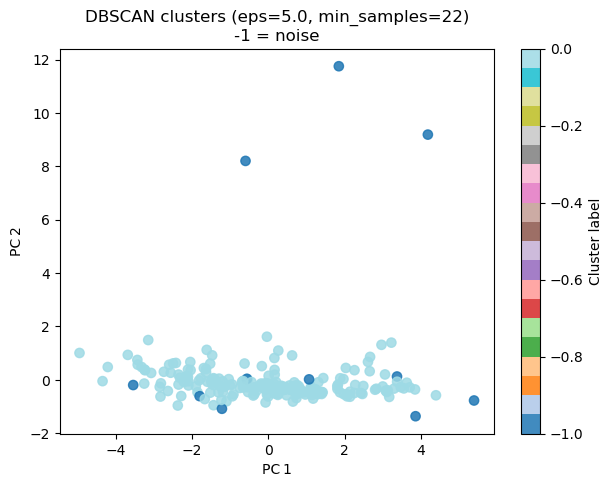

In [9]:
# ---------------------------------------------------------------
# 1 – Run DBSCAN with the chosen eps
# ---------------------------------------------------------------
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

EPS = 5.0          # <-- tweak ±0.2 after you inspect results
MIN_SAMPLES = 22   # dimensionality*2 rule (keep as‑is for now)

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels = db.fit_predict(pcs_for_model)   # -1 = noise/outlier

df_pca["cluster_db"] = labels           # attach to main DF

# ---------------------------------------------------------------
# 2 – Quick diagnostics
# ---------------------------------------------------------------
counts = df_pca["cluster_db"].value_counts().sort_index()
print("Cluster counts:\n", counts, "\n")

core_mask = labels != -1
if core_mask.sum() > 1 and len(np.unique(labels[core_mask])) > 1:
    sil = silhouette_score(pcs_for_model[core_mask], labels[core_mask])
    print(f"Silhouette (core points only): {sil:0.3f}")
else:
    print("Not enough clustered points to compute silhouette.")

# ---------------------------------------------------------------
# 3 – PC1 vs PC2 scatter coloured by DBSCAN labels
# ---------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    df_pca["pc1"], df_pca["pc2"],
    c=df_pca["cluster_db"], cmap="tab20", s=45, alpha=0.85
)
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.title(f"DBSCAN clusters (eps={EPS}, min_samples={MIN_SAMPLES})\n‑1 = noise")
plt.colorbar(scatter, label="Cluster label")
plt.show()


In [12]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_grid      = np.arange(0.8, 2.3, 0.2)     # much smaller eps
min_grid      = [6, 8, 10, 12, 15]           # looser min_samples
records = []

for eps in eps_grid:
    for ms in min_grid:
        db   = DBSCAN(eps=eps, min_samples=ms)
        labs = db.fit_predict(pcs_for_model)

        n_clust = len(set(labs)) - (1 if -1 in labs else 0)
        n_noise = (labs == -1).sum()

        if n_clust >= 2:
            mask = labs != -1
            sil  = silhouette_score(pcs_for_model[mask], labs[mask])
        else:
            sil  = np.nan

        records.append((eps, ms, n_clust, n_noise, sil))

res_tight = pd.DataFrame(
    records,
    columns=["eps","min_samples","#clusters","#noise","silhouette"]
).sort_values(["#clusters","silhouette"], ascending=[False,False])

res_tight.head(15)

,eps,min_samples,#clusters,#noise,silhouette
5,1.0,6,3,154,0.322380
12,1.2,10,2,122,0.430306
11,1.2,8,2,116,0.416670
10,1.2,6,2,97,0.405871
20,1.6,6,2,52,0.376687
18,1.4,12,2,85,0.373928
6,1.0,8,2,170,0.178621
7,1.0,10,1,195,NaN
13,1.2,12,1,137,NaN
14,1.2,15,1,162,NaN


In [13]:
import hdbscan

# tweak min_cluster_size ~ desired smallest meaningful group
hdb = hdbscan.HDBSCAN(
        min_cluster_size = 10,
        min_samples      = 10,   # can be <= min_cluster_size
        metric           = "euclidean"
)
df_pca["cluster_hdb"] = hdb.fit_predict(pcs_for_model)   # -1 = noise

# quick overview
print("HDBSCAN cluster counts:\n",
      df_pca["cluster_hdb"].value_counts().sort_index(), "\n")

# silhouette for HDBSCAN (ignore noise)
mask = df_pca["cluster_hdb"] != -1
if mask.sum() > 1 and df_pca["cluster_hdb"][mask].nunique() > 1:
    from sklearn.metrics import silhouette_score
    s = silhouette_score(pcs_for_model[mask], df_pca["cluster_hdb"][mask])
    print(f"Silhouette (core only): {s:0.3f}")


HDBSCAN cluster counts:
 cluster_hdb
-1    216
Name: count, dtype: int64 



c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Cleaning final CSVs

In [19]:
# ------------------------------------------------------------------
# 1.  Load both files
# ------------------------------------------------------------------
nopillars_df = pd.read_csv("./data/clean/cluster_no_pillars.csv")
pillars_df = pd.read_csv("./data/clean/cluster_pillars.csv")
pillars_df.rename(columns={"iso3.1": "iso3"}, inplace=True)   # real ISO‑3 codes

# ------------------------------------------------------------------
# 2.  Merge composite score onto the no‑pillar clustering
# ------------------------------------------------------------------
merged = nopillars_df.merge(
    pillars_df[["iso3", "composite_score"]],
    on="iso3",
    how="left"
)

merged.head(3)  # sanity‑check

,iso3,cluster,composite_score
0,ABW,2,0.062159
1,AFG,1,-0.839722
2,AGO,3,-0.462437


In [21]:
# ------------------------------------------------------------------
# 3.  Compute mean composite_score per cluster + rank & description
# ------------------------------------------------------------------
# merged   ← the DataFrame you just built in step 2
#           (cols: iso3, cluster, composite_score)

# -- a. summary stats ---------------------------------------------
stats = (merged
         .groupby("cluster")["composite_score"]
         .agg(cluster_mean="mean",  n_countries="count")
         .sort_values("cluster_mean", ascending=False)
)

# -- b. ranking: 1 = highest mean composite_score -----------------
stats["cluster_rank"] = stats["cluster_mean"]\
                            .rank(ascending=False, method="dense")\
                            .astype(int)

# -- c. generate a scalable text description ----------------------
total = stats["cluster_rank"].max()          # e.g. 11

def make_desc(rank, total):
    if rank == 1:
        return "Top‑performing cluster"
    elif rank <= total * 0.25:
        return "High performers"
    elif rank <= total * 0.50:
        return "Upper‑middle performers"
    elif rank <= total * 0.75:
        return "Lower‑middle performers"
    elif rank < total:
        return "Low performers"
    else:                  # last rank
        return "Lowest‑performing cluster"

stats["cluster_desc"] = stats["cluster_rank"].apply(lambda r: make_desc(r, total))

# peek
display(stats)

# ------------------------------------------------------------------
# 4.  Attach rank & description back to every country --------------
# ------------------------------------------------------------------
final = (merged
         .merge(stats[["cluster_rank", "cluster_desc"]],
                left_on="cluster", right_index=True, how="left")
        )

# ------------------------------------------------------------------
# 5.  Save enriched table
# ------------------------------------------------------------------
out_path = "./data/clean/cluster_no_pillars_with_rank_desc.csv"
final.to_csv(out_path, index=False)
print(f"✓  Saved → {out_path}")


,cluster_mean,n_countries,cluster_rank,cluster_desc
cluster,,,,
7,1.328830,1,1,Top‑performing cluster
5,1.241316,1,2,High performers
0,1.165753,2,3,Upper‑middle performers
4,0.524320,41,4,Upper‑middle performers
6,0.493000,3,5,Upper‑middle performers
2,0.026351,86,6,Lower‑middle performers
3,-0.315189,17,7,Lower‑middle performers
8,-0.321999,47,8,Lower‑middle performers
9,-0.428699,1,9,Low performers


✓  Saved → ./data/clean/cluster_no_pillars_with_rank_desc.csv


In [22]:
# ---------------------------------------------------------------
# 0.  Inputs: df_pca (first 11 PCs), nopillars_df
# ---------------------------------------------------------------
# If you no longer have 'explained' in RAM, regenerate from pca:
weights = pca.explained_variance_ratio_[:11]          # length 11

# --- A. Weighted sum of PCs ------------------------------------
pc_cols = [f"pc{i}" for i in range(1, 12)]
df_pca["composite_score_np"] = (df_pca[pc_cols] * weights).sum(axis=1)

# --- B. Align sign with the pillar composite (optional) ---------
# If you want higher = better AND you still have pillars_df:
corr = df_pca.merge(pillars_df[["iso3", "composite_score"]],
                    on="iso3")\
             [["composite_score_np", "composite_score"]].corr().iloc[0,1]

if corr < 0:
    df_pca["composite_score_np"] *= -1      # flip sign for consistency

# --- C. Rank countries globally --------------------------------
df_pca["country_rank_np"] = df_pca["composite_score_np"]\
                                .rank(ascending=False, method="min")\
                                .astype(int)

# --- D. Merge back into cluster_no_pillars ---------------------
enriched = (nopillars_df
            .merge(df_pca[["iso3", "composite_score_np", "country_rank_np"]],
                   on="iso3", how="left")
           )

# ---------------------------------------------------------------
# 1.  (Optional) sanity check
# ---------------------------------------------------------------
display(
    enriched
      .sort_values("country_rank_np")
      .head(15)[["iso3","cluster","country_rank_np","composite_score_np"]]
)

# ---------------------------------------------------------------
# 2.  Save
# ---------------------------------------------------------------
out_path = "./data/clean/cluster_no_pillars_with_country_rank.csv"
enriched.to_csv(out_path, index=False)
print(f"✓  Saved → {out_path}")


,iso3,cluster,country_rank_np,composite_score_np
117,MAC,0,1,2.063365
203,USA,6,2,2.000687
169,SGP,4,3,1.951141
120,MCO,5,4,1.760646
35,CHN,6,5,1.701825
115,LUX,4,6,1.138532
162,QAT,4,7,0.948308
5,ARE,4,8,0.943139
81,HKG,4,9,0.934050
92,ISL,4,10,0.899570


✓  Saved → ./data/clean/cluster_no_pillars_with_country_rank.csv


In [26]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/mnt/data")          # adjust if your notebook path differs

# ------------------------------------------------------------------
# 1 – Load the two latest CSVs
# ------------------------------------------------------------------
df_core   = pd.read_csv("./data/clean/cluster_no_pillars_.csv")
df_scores = pd.read_csv("./data/clean/cluster_no_pillars_with_country_rank.csv")

# quick sanity‑check
assert "iso3" in df_core.columns and "iso3" in df_scores.columns, \
       "Both CSVs must contain an 'iso3' column!"

# ------------------------------------------------------------------
# 2 – Outer merge to keep every country once
#     (suffix '_y' marks any column name collision)
# ------------------------------------------------------------------
merged = pd.merge(
    df_core,
    df_scores,
    on="iso3",
    how="outer",
    suffixes=("", "_y")          # original col keeps its name; duplicates get _y
)

# ------------------------------------------------------------------
# 3 – De‑duplicate any overlapping columns
# ------------------------------------------------------------------
for col in merged.columns:
    if col.endswith("_y"):
        base = col[:-2]          # strip "_y"
        # if both versions exist and are truly identical, drop the duplicate
        if base in merged.columns and merged[base].equals(merged[col]):
            merged = merged.drop(columns=[col])
        else:
            # keep both but rename the second one clearly
            merged = merged.rename(columns={col: f"{base}_alt"})

# ------------------------------------------------------------------
# 4 – Save the finished master file
# ------------------------------------------------------------------
merged.to_csv("cluster_no_pillars_final.csv")
print(f"✓  Master CSV saved → {out_path}\n"
      f"   Rows: {merged.shape[0]}  |  Columns: {merged.shape[1]}")


✓  Master CSV saved → \mnt\data\cluster_no_pillars_final.csv
   Rows: 216  |  Columns: 7
